In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from tabulate import tabulate
from astropy.time import Time
from tqdm import tqdm
import csv
import os
import glob
import multiprocessing

In [2]:
df_vlass = pd.read_pickle('/datax/scratch/ellambishop/new_hits_organized/vlass_other.pkl')
#df_vlass.groupby('tstart').size()
df_vlass.columns


Index(['id', 'beam_id', 'observation_id', 'tuning', 'subband_offset',
       'file_uri', 'file_local_enumeration', 'signal_frequency',
       'signal_index', 'signal_drift_steps', 'signal_drift_rate', 'signal_snr',
       'signal_coarse_channel', 'signal_beam', 'signal_num_timesteps',
       'signal_power', 'signal_incoherent_power', 'source_name', 'fch1_mhz',
       'foff_mhz', 'tstart', 'tsamp', 'ra_hours', 'dec_degrees',
       'telescope_id', 'num_timesteps', 'num_channels', 'coarse_channel',
       'start_channel'],
      dtype='object')

In [3]:
#clean out initial drift rates=0 and snr > 16
def set_filter(file, drift_max=0):
    # Load and slice dataset
    global df_new
    df = file
   # print(df.columns)
    #small_df = df[start:stop]

    # Select relevant columns
    columns = ['file_uri', 'observation_id','source_name', 'beam_id', 'ra_hours', 'dec_degrees', 'tstart',
               'signal_frequency', 'signal_beam', 'signal_drift_rate', 'signal_snr',
               'signal_power', 'signal_incoherent_power', 'signal_num_timesteps']
    df_new = df[columns]

    # Apply filtering thresholds
    df_new = df_new[(df_new['signal_drift_rate'] != drift_max)]
    df_new = df_new[(df_new['signal_snr'])<=16]
    df_new['signal_frequency'] = df_new['signal_frequency'].round(3)    
    
    print(df_new.groupby('signal_frequency').size())
    return df_new

#set_filter(df_vlass)


In [4]:
#rfi filtering based on time step- snr ranges and frequency overlap flagging
def processing(df):
    """
    Processes filtered DataFrame by grouping on (file_uri, observation_id),
    flags RFI based on conditions, and returns the flagged DataFrame.
    """
    # Apply initial filtering
    df_new = set_filter(df)

    # Group by file_uri and observation_id
    grouped = df_new.groupby(['file_uri', 'observation_id'])
    flagged_dfs = []

    for (file_uri, obs_id), group_df in grouped:
        group_df = group_df.copy()
        group_df['rfi_flag'] = False
        group_df['flag_strength'] = 0

        # Conditions to drop hits
        cond1 = (
            (group_df['signal_num_timesteps'] >= 16) &
            (group_df['signal_num_timesteps'] <= 64) &
            (group_df['signal_snr'] > 10)
        )
        cond2 = (
            (group_df['signal_num_timesteps'] < 16) &
            (group_df['signal_snr'] > 15)
        )

        drop_mask = cond1 | cond2
        group_df = group_df.loc[~drop_mask]

        # Flag overlapping frequencies at same tstart
        overlap_indices = []
        for t_value, t_df in group_df.groupby('tstart'):
            freq_counts = t_df['signal_frequency'].value_counts()
            overlapping_freqs = freq_counts[freq_counts > 1].index
            for freq in overlapping_freqs:
                hits = t_df[t_df['signal_frequency'] == freq]
                overlap_indices.extend(hits.index.tolist())

        group_df.loc[overlap_indices, 'rfi_flag'] = True
        group_df.loc[overlap_indices, 'flag_strength'] += 1

        
        flagged_dfs.append(group_df)

    full_df = pd.concat(flagged_dfs, ignore_index=True)

    return full_df
#processing()


In [5]:
full_df= processing(df_vlass)

signal_frequency
2290.822     3
2290.876     1
2290.877     2
2290.878     8
2290.880     3
            ..
3699.913     1
3699.915    30
3699.917     4
3699.919    49
3699.963    24
Length: 21234, dtype: int64


In [6]:
#convert time to dates and flag the different NRAO configurations 
from astropy.time import Time
import datetime

# Extended VLA configuration date ranges to fill gaps
vla_config_ranges = [
    (datetime.date(2023, 1, 19), datetime.date(2023, 5, 29), 'B'),
    (datetime.date(2023, 6, 2),  datetime.date(2023, 6, 19), 'BnA'),
    (datetime.date(2023, 6, 30), datetime.date(2023, 10, 2), 'A'),
    (datetime.date(2023, 10, 20), datetime.date(2024, 1, 15), 'D'),
    (datetime.date(2024, 1, 25), datetime.date(2024, 5, 7), 'C'),   # Gap filled
    (datetime.date(2024, 5, 8),  datetime.date(2024, 9, 16), 'B'),
    (datetime.date(2024, 9, 17), datetime.date(2024, 10, 7), 'BnA'), # Gap filled
    (datetime.date(2024, 10, 8), datetime.date(2025, 2, 3), 'A'),   # Gap filled
]

dates = []
configs = []

for t in full_df['tstart']:
    try:
        time = Time(t, format='mjd')
        date_str = time.to_value('iso', subfmt='date')
        date_obj = datetime.datetime.strptime(date_str, "%Y-%m-%d").date()
        dates.append(date_str)

        matched_config = 'Unknown'
        for start, end, config in vla_config_ranges:
            if start <= date_obj <= end:
                matched_config = config
                break
        configs.append(matched_config)

    except Exception as e:
        print(f"[!] Error parsing tstart={t}: {e}")
        dates.append('Invalid')
        configs.append('Unknown')

full_df['date'] = dates
full_df['config'] = configs

print(full_df['config'].value_counts())

config
B    163298
C     13754
Name: count, dtype: int64


In [7]:
# calculate beam size for each hit to use in beam overlap calculations

band_ranges_mhz = {
    'S':  (2000, 4000),   # 3.0 GHz
    'C':  (4000, 8000),   # 6.0 GHz
    'X':  (8000, 12000),  # 10 GHz
}

# Beam size per band and configuration (arcsec)
beam_resolutions = {
    'S':  {'D': 23,   'C': 7.0,  'B': 2.1,  'A': 0.65},
    'C':  {'D': 12,   'C': 3.5,  'B': 1.0,  'A': 0.33},
    'X':  {'D': 7.2,  'C': 2.1,  'B': 0.6,  'A': 0.20},
}

def get_band_mhz(freq_mhz):
    for band, (low, high) in band_ranges_mhz.items():
        if low <= freq_mhz < high:
            return band
    return None

def lookup_beam_size_mhz(freq_mhz, config):
    band = get_band_mhz(freq_mhz)
    if band and config in beam_resolutions[band]:
        return beam_resolutions[band][config]
    return None  # or np.nan if you're using pandas

full_df['beam_size_arcsec'] = full_df.apply(
    lambda row: lookup_beam_size_mhz(row['signal_frequency'], row['config']), axis=1
)


In [8]:
#flag overlapping signals in spacially separated beams as rfi, same file uri/fov 
def flag_local_rfi(df):
    from scipy.spatial import ConvexHull
    import numpy as np
    from astropy.coordinates import SkyCoord
    import astropy.units as u

    local_flag_count = 0
    unique_freqs = sorted(df['signal_frequency'].unique())

    for freq in unique_freqs:
        freq_subset = df[df['signal_frequency'] == freq]
        for fov in freq_subset['file_uri'].unique():
            subset = freq_subset[freq_subset['file_uri'] == fov]

            if len(subset['signal_beam'].unique()) <= 1 or len(subset) < 3:
                continue

            ra0, dec0 = np.mean(subset['ra_hours']), np.mean(subset['dec_degrees'])
            ra_offsets = (subset['ra_hours'] - ra0) * 3600 * np.cos(np.deg2rad(dec0))
            dec_offsets = (subset['dec_degrees'] - dec0) * 3600
            points = np.vstack([ra_offsets, dec_offsets]).T

            try:
                hull = ConvexHull(points)
                hit_area = hull.area
            except:
                hit_area = 0

            avg_beam_size = subset['beam_size_arcsec'].mean()
            beam_area = np.pi * (avg_beam_size / 2)**2
            threshold_area = 3 * beam_area

            if hit_area > threshold_area:
                df.loc[subset.index, 'rfi_flag_local'] = True
                local_flag_count += len(subset)

    return df, local_flag_count


In [9]:
#global overlap beam frequency rfi 
from scipy.spatial.distance import pdist, squareform
import numpy as np

def flag_global_rfi(df, min_fov_count=5, separation_threshold_arcsec=1000):
    df['rfi_flag_global'] = False
    global_flag_count = 0
    
    # Precompute FOV positions once
    fov_positions = df.groupby('file_uri').agg({'ra_hours':'mean', 'dec_degrees':'mean'})
    
    freq_fov_counts = df.groupby('signal_frequency')['file_uri'].nunique()
    candidate_freqs = freq_fov_counts[freq_fov_counts >= min_fov_count].index
    
    for freq in candidate_freqs:
        freq_subset = df[df['signal_frequency'] == freq]
        fov_list = freq_subset['file_uri'].unique()
        
        coords = fov_positions.loc[fov_list][['ra_hours','dec_degrees']].values
        dec_mean = np.mean(coords[:,1])
        ra_offsets = (coords[:,0] - np.mean(coords[:,0])) * 3600 * np.cos(np.deg2rad(dec_mean))
        dec_offsets = (coords[:,1] - np.mean(coords[:,1])) * 3600
        points = np.vstack([ra_offsets, dec_offsets]).T
        
        dist_matrix = squareform(pdist(points))  # in arcseconds
        
        # Find pairs with distance > threshold
        pairs_to_flag = np.argwhere(dist_matrix > separation_threshold_arcsec)
        
        # Avoid duplicate pairs (i,j) and (j,i)
        pairs_to_flag = pairs_to_flag[pairs_to_flag[:,0] < pairs_to_flag[:,1]]
        
        flagged_fovs = set()
        for i,j in pairs_to_flag:
            flagged_fovs.add(fov_list[i])
            flagged_fovs.add(fov_list[j])
        
        # Flag all hits in these FOVs at this freq
        if flagged_fovs:
            mask = (df['signal_frequency'] == freq) & (df['file_uri'].isin(flagged_fovs))
            df.loc[mask, 'rfi_flag_global'] = True
            global_flag_count += mask.sum()
    
    return df, global_flag_count



In [10]:
full_df['rfi_flag_local'] = False
full_df['rfi_flag_global'] = False

full_df, local_count = flag_local_rfi(full_df)
full_df, global_count = flag_global_rfi(full_df)

# Combine flags into one final flag column:
full_df['rfi_flag'] = full_df['rfi_flag_local'] | full_df['rfi_flag_global']

print(f"Local RFI flagged: {local_count}")
print(f"Global RFI flagged: {global_count}")
print(f"Total flagged: {full_df['rfi_flag'].sum()}")

Local RFI flagged: 53914
Global RFI flagged: 145349
Total flagged: 153304


In [11]:
# dividing up df based on flags 
full_df.groupby('flag_strength').size()
clean_df = full_df[full_df['flag_strength'] == 0]         # High-confidence real
maybe_rfi = full_df[full_df['flag_strength'] == 1]        # Weak RFI flag
strong_rfi = full_df[full_df['flag_strength'] >= 2]       # Remove from science set

print(len(full_df),len(clean_df))

177052 70849


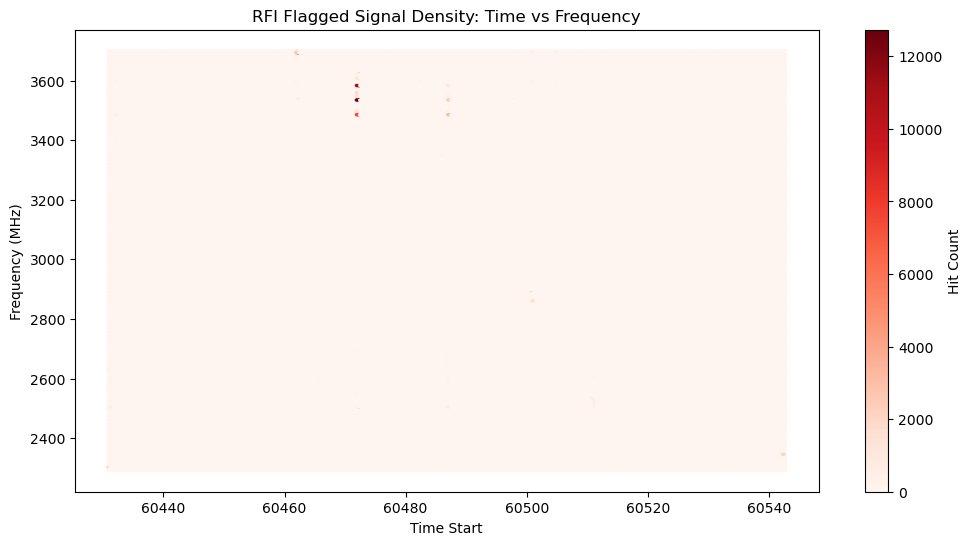

In [12]:
# signal density/ timevs freq
rfi_only = full_df[full_df['rfi_flag']==True]
plt.figure(figsize=(12, 6))
plt.hexbin(rfi_only['tstart'], rfi_only['signal_frequency'], gridsize=200, cmap='Reds')
plt.xlabel("Time Start")
plt.ylabel("Frequency (MHz)")
plt.title("RFI Flagged Signal Density: Time vs Frequency")
plt.colorbar(label='Hit Count')
plt.show()

In [13]:
import pandas as pd

# Define RFI intervals: [start_freq, end_freq, label]
data = [
    [2178.0, 2195.0, "Unknown"],
    [2106.4, 2106.4, "High alt balloon (FT Sumner)"],
    [2204.5, 2204.5, "Test telemetry (FT Bliss)"],
    [2180.0, 2290.0, "Satellite downlink (GSO/MEO)"],
    [2227.5, 2231.5, "Unknown (WSMR?)"],
    [2246.5, 2252.5, "Unknown (WSMR?)"],
    [2268.5, 2274.5, "Unknown (WSMR?)"],
    [2282.5, 2288.5, "Unknown (WSMR?)"],
    [2314.5, 2320.5, "Unknown (WSMR?)"],
    [2320.0, 2332.5, "Sirius DARS (GSO-Tundra)"],
    [2324.5, 2330.5, "Unknown (WSMR?)"],
    [2332.5, 2345.0, "XM DARS (GSO-Equatorial)"],
    [2334.5, 2340.5, "Unknown (WSMR?)"],
    [2387.5, 2387.5, "High alt balloon (FT Sumner)"],
    [2400.0, 2483.5, "Microwave Ovens"],
    [2400.0, 2483.5, "WiFi (802.11b) Wireless"],
    [2411.0, 2413.0, "Hughes Net WiFi"],
    [2483.5, 2500.0, "GlobalStar downlink"],
    [2741.0, 2741.0, "ABQ NEXRAD1"],
    [2791.0, 2791.0, "ABQ NEXRAD1"],
    [3700.0, 4200.0, "Satellite downlinks"],
]

# Create DataFrame
intervals = pd.DataFrame(data, columns=["start_frequency", "end_frequency", "label"])

# Save to CSV
intervals.to_csv("Known_s-band_RFI.csv", index=False)

print("Saved 'Known_s-band_RFI.csv' with", len(intervals), "intervals.")


Saved 'Known_s-band_RFI.csv' with 21 intervals.


CSV columns: ['start_frequency', 'end_frequency', 'label']


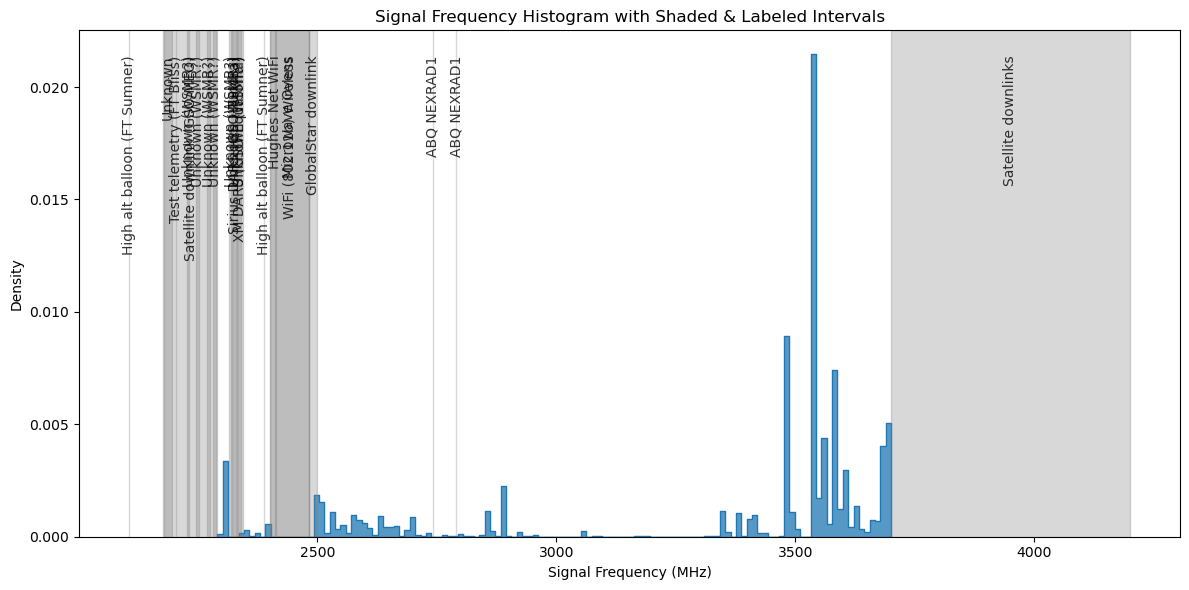

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# Load signal data (for histogram)
df = clean_df

# Load interval data (to shade)
intervals = pd.read_csv("Known_s-band_RFI.csv")
print("CSV columns:", intervals.columns.tolist())
# Start the plot
plt.figure(figsize=(12, 6))


# Plot histogram
sns.histplot(
    data=df,
    x="signal_frequency",
    #hue="date",
    element="step",
    stat="density",
    common_norm=False
)

# Add shaded regions and text labels
for _, row in intervals.iterrows():
    # Draw the shaded band
    plt.axvspan(row['start_frequency'], row['end_frequency'], color='gray', alpha=0.3)

    # Add the label at the center of the span
    center_x = (row['start_frequency'] + row['end_frequency']) / 2
    plt.text(
        center_x,
        plt.ylim()[1] * 0.95,  # near top of plot
        row['label'],
        ha='center',
        va='top',
        fontsize=10,
        color='black',
        alpha=0.8,
        rotation=90  # optional: vertical text
    )

# Add legend patch manually for shaded regions
#shaded_patch = Patch(facecolor='gray', alpha=0.3, label='RFI')
#plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + [shaded_patch])

# Final touches
plt.xlabel("Signal Frequency (MHz)")
plt.ylabel("Density")
#plt.xlim(5800,7500)
plt.title("Signal Frequency Histogram with Shaded & Labeled Intervals")
plt.tight_layout()
plt.show()

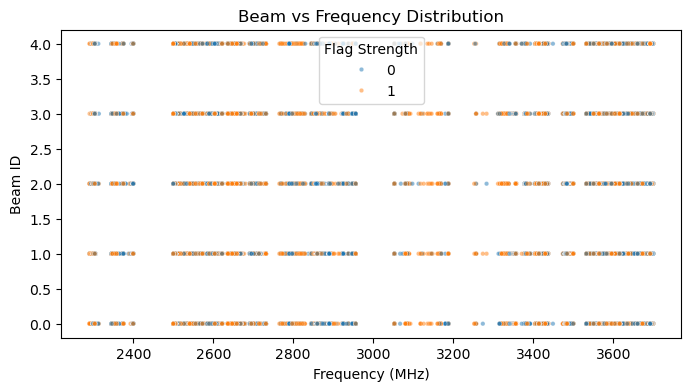

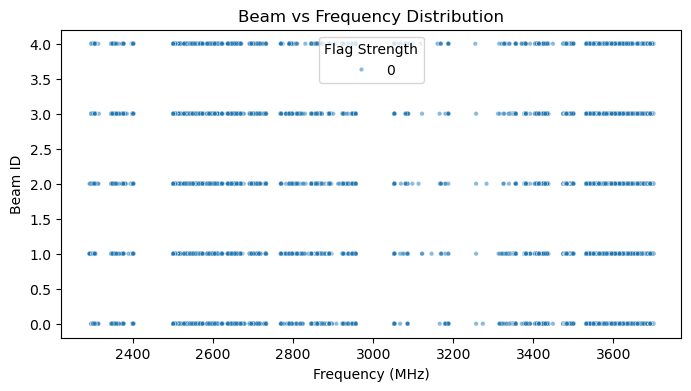

In [15]:

plt.figure(figsize=(8, 4))
sns.scatterplot(data=full_df, x='signal_frequency', y='signal_beam', hue='flag_strength', s=10, alpha=0.5)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Beam ID")
plt.title("Beam vs Frequency Distribution")
plt.legend(title='Flag Strength')
plt.show()

plt.figure(figsize=(8, 4))
sns.scatterplot(data=clean_df, x='signal_frequency', y='signal_beam', hue='flag_strength', s=10, alpha=0.5)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Beam ID")
plt.title("Beam vs Frequency Distribution")
plt.legend(title='Flag Strength')
plt.show()

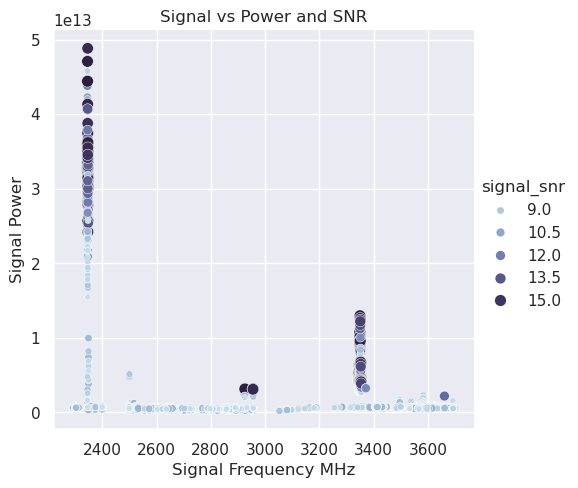

In [16]:
#visualize signal vs power with snr value incuded 
def pow_freq_snr(full_df):
    df_new = full_df
    sns.set_theme()
    sns.relplot(data=df_new, x=df_new["signal_frequency"], y=df_new["signal_power"], 
                hue=df_new["signal_snr"], size = df_new["signal_snr"], palette = "ch:s=.25,rot=-.25")
 
    plt.xlabel("Signal Frequency MHz")
    plt.ylabel("Signal Power")
    plt.title("Signal vs Power and SNR")
    plt.grid(True)
    plt.show()

pow_freq_snr(clean_df)

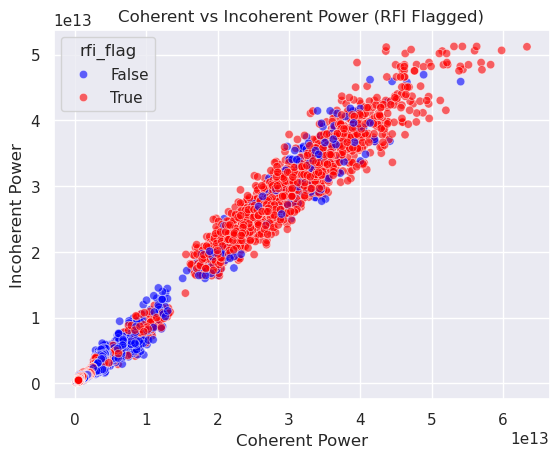

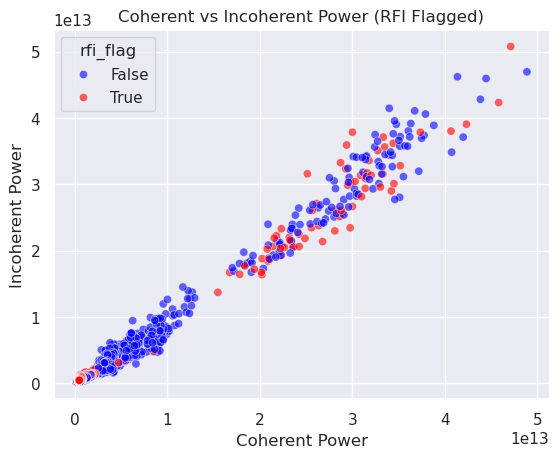

In [17]:
#visualize incoh to coh power with rfi flags included 

df_1 = full_df

sns.scatterplot(
    data=df_1,
    x='signal_power',  # coherent
    y='signal_incoherent_power',
    hue='rfi_flag',
    palette={False: 'blue', True: 'red'},
    alpha=0.6
)
plt.xlabel("Coherent Power")
plt.ylabel("Incoherent Power")
plt.title("Coherent vs Incoherent Power (RFI Flagged)")
plt.grid(True)
plt.show()

df_2 = clean_df
sns.scatterplot(
    data=df_2,
    x='signal_power',  # coherent
    y='signal_incoherent_power',
    hue='rfi_flag',
    palette={False: 'blue', True: 'red'},
    alpha=0.6
)
plt.xlabel("Coherent Power")
plt.ylabel("Incoherent Power")
plt.title("Coherent vs Incoherent Power (RFI Flagged)")
plt.grid(True)
plt.show()

Excess Kurtosis: 0.7783668693584955
Skewness: 0.713422883520151


/tmp/ipykernel_289637/1914982559.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_rfi_df['power_ratio'] = non_rfi_df['signal_power'] / (non_rfi_df['signal_incoherent_power'] + 1e-9)


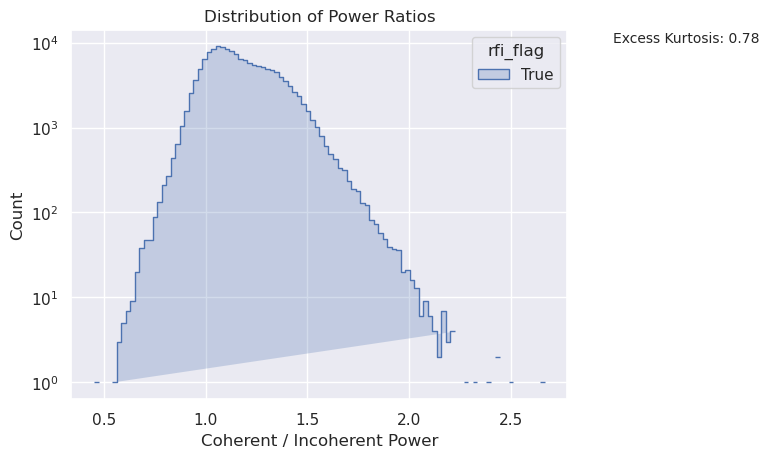

Excess Kurtosis: 1.2572576313333386
Skewness: 0.7820582022340243


/tmp/ipykernel_289637/1914982559.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_rfi_df['power_ratio'] = non_rfi_df['signal_power'] / (non_rfi_df['signal_incoherent_power'] + 1e-9)


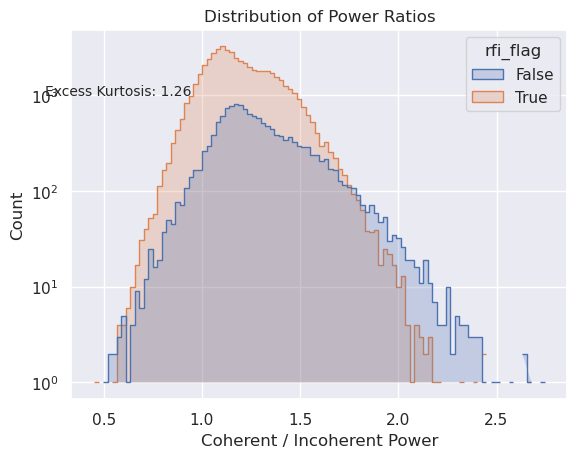

In [18]:
# visualize distribution of power ratios across data set/ time 
from scipy.stats import kurtosis, skew

non_rfi_df = full_df[full_df['rfi_flag'] == True]
ratios = non_rfi_df['signal_power'] / non_rfi_df['signal_incoherent_power']
ratios = ratios.replace([np.inf, -np.inf], np.nan).dropna()
excess_kurt = kurtosis(ratios, fisher=True)
print("Excess Kurtosis:", kurtosis(ratios, fisher=True))  # >0 = heavy tail
print("Skewness:", skew(ratios))

non_rfi_df['power_ratio'] = non_rfi_df['signal_power'] / (non_rfi_df['signal_incoherent_power'] + 1e-9)
sns.histplot(data=non_rfi_df, x='power_ratio', hue='rfi_flag', bins=100, log_scale=(False, True), element='step')  
plt.text(3, 1e4, f'Excess Kurtosis: {excess_kurt:.2f}', fontsize=10)
plt.title("Distribution of Power Ratios")
plt.xlabel("Coherent / Incoherent Power")
plt.grid(True)
plt.show()



non_rfi_df = clean_df
ratios = non_rfi_df['signal_power'] / non_rfi_df['signal_incoherent_power']
ratios = ratios.replace([np.inf, -np.inf], np.nan).dropna()
excess_kurt = kurtosis(ratios, fisher=True)

print("Excess Kurtosis:", kurtosis(ratios, fisher=True))  # >0 = heavy tail
print("Skewness:", skew(ratios))

non_rfi_df['power_ratio'] = non_rfi_df['signal_power'] / (non_rfi_df['signal_incoherent_power'] + 1e-9)
sns.histplot(data=non_rfi_df, x='power_ratio', hue='rfi_flag', bins=100, log_scale=(False, True), element='step')  
plt.text(0.2, 1e3, f'Excess Kurtosis: {excess_kurt:.2f}', fontsize=10)
plt.title("Distribution of Power Ratios")
plt.xlabel("Coherent / Incoherent Power")
plt.grid(True)
plt.show()

clean_df.to_pickle('data/clean_df.pkl')

#save in pickle file in scratch space 

full_df.columns